In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set plot style
custom_style = {'figure.facecolor':'.4',
                "axes.facecolor":".4",
                'axes.edgecolor':'.4',
                "axes.labelcolor":"white",
                "axes.grid":True,
                'grid.color':'white',
                "text.color":"white",
                "patch_edgecolor":'white',
                "xtick.color":"white",
                "ytick.color":"white",
                'axes.edgecolor':'black',
               'legend.frameon':True}
sns.set_style('whitegrid')
sns.set_context('poster')
col_palette = sns.color_palette("husl")
gender_palette = sns.color_palette(['#1258DC','#C21460']) # M F
geno_palette = sns.color_palette(['#305A30','#A70F01']) # WT Df1
gengen_palette = sns.color_palette(['#305A30','#A70F01','#559E54','#FE2712']) # WT_M Df1_M WT_F Df1_F
anim_palette = sns.color_palette(['#92C591','#559E54','#305A30','#0A3409','#FE8176','#FE2712','#A70F01','#882216']) # RW7 RW8 RW9 RW10 RZ7 RZ8 RZ9 RZ10
specAnim_palette = sns.color_palette(['#305A30','#0A3409','#A70F01','#882216']) # RW9 RW10 RZ9 RZ10
bandAnim_palette = sns.color_palette(['#92C591','#FE8176','#559E54','#FE2712','#305A30','#A70F01','#0A3409','#882216']) # RW7 RZ7 RW8 RZ8 RW9 RZ9 RW10 RZ10
epoch_palette = sns.color_palette(['#2E2FE3','#FB8604','#448D76']) # Baseline Saline Ketamine
state_palette = sns.color_palette(['#448D76','#FB8604','#EA202C'])
palDict = {'genotype':geno_palette,
           'gender': gender_palette,
           'geno_gender':gengen_palette,
           'animal':anim_palette,
           'epoch_name':epoch_palette,
           'spec_animal':specAnim_palette,
           'state_name':state_palette,
           'band_animal':bandAnim_palette}
groupOrders = {'genotype':['WT','Df1'],
               'gender':['M','F'],
               'geno_gender':['WT_M','Df1_M','WT_F','Df1_F'],
               'animal':['RW7','RW8','RW9','RW10','RZ7','RZ8','RZ9','RZ10'],
               'epoch_name':['Baseline','Saline','Ketamine'],
               'spec_animal':['RW9','RW10','RZ9','RZ10'],
               'state_name':['NREM','Rest','Active'],
               'band_animal':['RW7','RZ7','RW8','RZ8','RW9','RZ9','RW10','RZ10']}
def addTitle(fig=None,title='',adj=0.85):
    plt.subplots_adjust(top=adj)
    fig.fig.suptitle(title)

In [3]:
traceList = []
specList = []
bandList = []
project_path = '/data/Projects/'
figure_dir = project_path+'rn_Schizophrenia_Project/SFN2018_Figures/'

for dirpath,dirnames,files in os.walk(project_path):
    for name in files:
        if name.endswith('deltaTraceMatrix.csv'):
            traceList.append(os.path.join(dirpath+'/'+name))
        if name.endswith('sleepSpecMatrix.csv'):
            specList.append(os.path.join(dirpath+'/'+name))
        if name.endswith('sleepBandPowerMatrix.csv'):
            bandList.append(os.path.join(dirpath+'/'+name))

In [4]:
def logMean(x):
    tmp = np.mean(x)
    return 10*np.log10(tmp)
def spec_plot(data,method,group,hue='state_name',asp=1.33,group_order=None,nBoot=1000,hue_order=None):
    if hue_order is None:
        hue_order = groupOrders[hue]
    if group_order is None:
        group_order = groupOrders[group]
    palette = palDict[hue]
    yCol = method+'_Power'
    if len(data[group].unique())>4:
        legend_y = 1.2
        cWrap=4
        shift = 0.9
    else:
        legend_y = 1.05
        cWrap=len(data[group].unique())
        shift = 0.8
    g = sns.FacetGrid(data=data,col=group,hue=hue,hue_order=hue_order,
                      margin_titles=True,
                      palette=palette,col_order=group_order,height=6,aspect=asp,col_wrap=cWrap)
    g = g.map(sns.lineplot,'frequency',yCol,sort=True,n_boot=nBoot,estimator=logMean,ci=68)
    plt.subplots_adjust(top=shift)
    g.fig.suptitle('Mean '+method+' Spectra')
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    g.set_axis_labels('','')
    g.fig.text(0.5,0,'Frequency (Hz)',ha='center',fontsize=24)
    g.fig.text(0,.5,method+' Power (dB)',rotation=90,va='center',fontsize=24)
    legend = plt.legend(loc='upper right', bbox_to_anchor=(1.1, legend_y),
                        ncol=1, fancybox=True, shadow=True,fontsize=18)
    g.despine()
    return g

In [5]:
def trace_plot(data,method,group,group_order=None,nBoot=1000,hue='epoch_name'):
    if group_order is None:
        group_order = groupOrders[group]
    if group is 'animal':
        group_order = groupOrders['spec_animal']
    hue_order = groupOrders[hue]
    palette = palDict[hue]
    yCol = method+'_delta_power'
    g = sns.FacetGrid(data,hue=hue,row=group,col=hue,
                      margin_titles=True,sharex=False,height=5,aspect=2,
                      row_order=group_order,palette=palette,col_order=hue_order)
    g = g.map(sns.lineplot,'epoch_minutes',yCol,n_boot=nBoot,ci=68)
    plt.subplots_adjust(top=0.88)
    g.fig.suptitle(method+' Delta Power')
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    g.set_axis_labels('','')
    g.fig.text(0,.5,'Normalized '+method+' Power',rotation=90,va='center',fontsize=24)
    g.fig.text(0.5,0,'Time (min)',ha='center',fontsize=24)
    g.despine()
    return g

In [6]:
def bar_plot(data,method,measure,group,hue='state_name',col=None,
             nBoot=1000,col_order=None,row_order=['delta','theta'],
             row='power_band'):
    hue_order = groupOrders[hue]
    group_order = groupOrders[group]
    palette = palDict[hue]
    if hue is 'animal':
        hue_order = groupOrders['band_animal']
        palette = palDict['band_animal']
    yCol = method+'_'+measure
    if len(data[group].unique())>4:
        legend_y = 1.2
        cWrap=4
    else:
        legend_y = 1.3
        cWrap=2
    if row is not None:
        cWrap=None
    g = sns.catplot(kind='bar',data=data,x=group,y=yCol,col=col,hue=hue,
                    margin_titles=True,row=row,n_boot=nBoot,order=group_order,
                    row_order=row_order,col_order=col_order,height=5,aspect=2,col_wrap=cWrap,
                    hue_order=hue_order,legend=False,palette=palette)
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(method+' Band Power')
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    legend = g.axes.flat[0].legend(loc='center', bbox_to_anchor=(1.25, 0),
                        ncol=1, fancybox=True, shadow=True,fontsize=18)
    g.set_axis_labels('','')
    g.fig.text(0.01,0.5,method+' '+measure+' Power',rotation=90,va='center',fontsize=24)
    g.fig.text(0.5,0.03,'Frequency (Hz)',ha='center',fontsize=24)
    g.despine()
    return g
                    

In [7]:
exclusions = ('state_name=="Artifact"',
              'state_name=="Transition"',
              'state_name=="REM"',
              'animal=="RW9" and (state_name=="Active" or tetrode==6)', # allow Active in trace plots
              'animal=="RW7" and day==5',
              'animal=="RZ7" and day==3',
              'animal=="RZ9" and day==5 and tetrode==8',
              'epoch_name=="Home"')
qStr = 'not ('+') and not ('.join(exclusions)+')'
traceExclusions = ('state_name=="Artifact"',
              'animal=="RW9" and tetrode==6', # allow Active, REM and Transition in trace plots
              'animal=="RW7" and day==5',
              'animal=="RZ7" and day==3',
              'animal=="RZ9" and day==5 and tetrode==8',
              'epoch_name=="Home"',
              'gender=="F"')
tqStr = 'not ('+') and not ('.join(traceExclusions)+')'

In [8]:
traceMat = pd.DataFrame()
#specMat = pd.DataFrame()
#bandMat = pd.DataFrame()
for rf in traceList:
    tmp = pd.read_csv(rf)
    traceMat = traceMat.append(tmp)
#for rf in specList:
#    tmp = pd.read_csv(rf)
#    specMat = specMat.append(tmp)
#for rf in bandList:
#    tmp = pd.read_csv(rf)
#    bandMat = bandMat.append(tmp)
traceMat = traceMat.reset_index(drop=True)
#bandMat = bandMat.reset_index(drop=True)
#specMat = specMat.reset_index(drop=True)
print('Data Loaded!')

Data Loaded!


In [9]:
# Change Epoch Names (Baseline, Saline, Ketamine, Home)
# Change Band Names (Delta, Theta)
bandDict = {'delta':'Delta','theta':'Theta'}
#bandMat['power_band']=bandMat['power_band'].map(bandDict)
epochDict = {'Sleep':'Baseline','Saline':'Saline','Ketamine':'Ketamine','Home':'Home'}
traceMat['epoch_name'] = traceMat['epoch_type'].map(epochDict)
#specMat['epoch_name'] = specMat['epoch_type'].map(epochDict)
#bandMat['epoch_name'] = bandMat['epoch_type'].map(epochDict)

# Make epoch timestamps
traceMat['epoch_timestamp'] = pd.to_datetime(traceMat['epoch_time'],unit='s')
traceMat['epoch_minutes'] = traceMat['epoch_time']/60

# Make geno_gender column
#specMat['geno_gender'] = specMat['genotype'].map(str) + '_' + specMat['gender']
#bandMat['geno_gender'] = bandMat['genotype'].map(str) + '_' + bandMat['gender']

In [10]:
# Add state names
stateDict = {1:'REM',2:'NREM',3:'Rest',4:'Active',5:'Transition',6:'Artifact'}
#bandMat['state_name']=bandMat['sleep_state'].map(stateDict)
#specMat['state_name']=specMat['sleep_state'].map(stateDict)
traceMat['state_name']=traceMat['sleep_state'].map(stateDict)

In [27]:
# Exclude
tmpDat = traceMat.query(tqStr)
#bandDat = bandMat.query(qStr)
#specDat = specMat.query(qStr)

# At each timepoint average over tetrodes
avgDat = traceMat.groupby(['animal','genotype','day','epoch_name','epoch_time','epoch_timestamp','epoch_minutes']).mean().reset_index().drop('tetrode',axis=1).sort_values(by=['animal','day','epoch_name','epoch_time'])

# Group and bin and smooth traces
# TODO: Smooth
traceDat = avgDat.groupby(
    ['animal','genotype','day','epoch_name']
    )['epoch_timestamp','epoch_time','epoch_minutes','age','sleep_state',
      'STFT_delta_power','CWT_delta_power'].resample('45S',on='epoch_timestamp').mean()
traceDat = traceDat.reset_index()
traceDat = traceDat.query('not (epoch_name=="Baseline" and epoch_minutes>60) and not (epoch_name!="Baseline" and epoch_minutes>30)')

In [28]:
traceDat = traceDat.loc[:,['animal','genotype','day','epoch_name','epoch_time','epoch_minutes','age','CWT_delta_power']]
traceDat.head()

,animal,genotype,day,epoch_name,epoch_time,epoch_minutes,age,CWT_delta_power
0,RW10,WT,1,Baseline,22,0.366667,143.0,0.616886
1,RW10,WT,1,Baseline,67,1.116667,143.0,0.827896
2,RW10,WT,1,Baseline,112,1.866667,143.0,0.889048
3,RW10,WT,1,Baseline,157,2.616667,143.0,0.498907
4,RW10,WT,1,Baseline,202,3.366667,143.0,0.894899


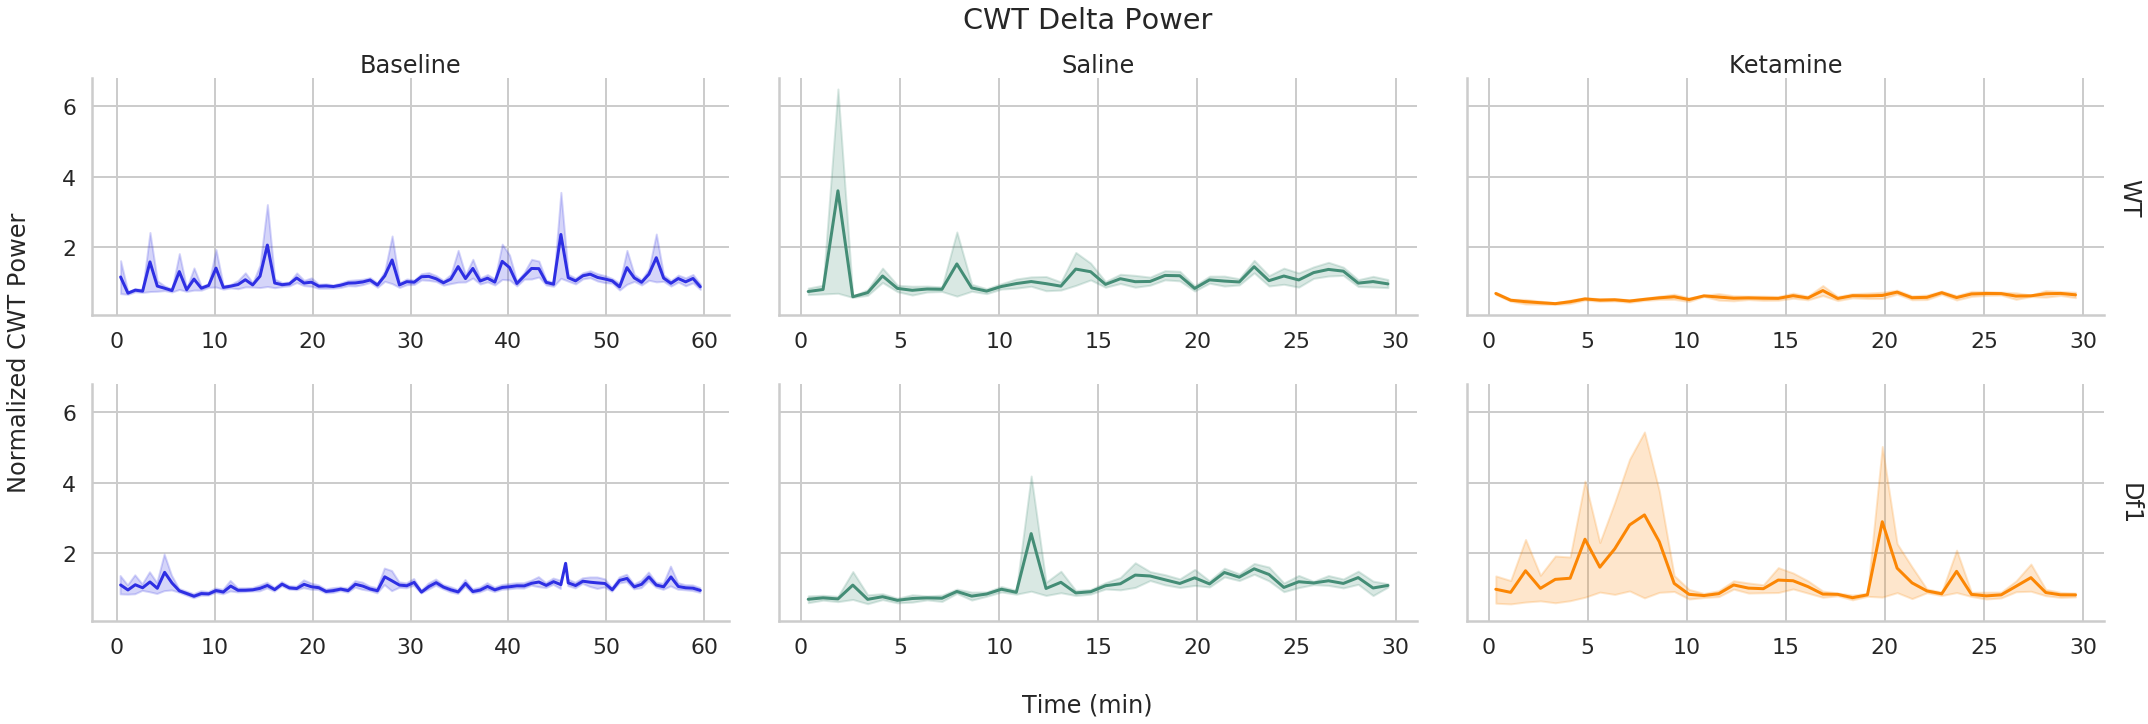

In [29]:
tp = trace_plot(traceDat,'CWT','genotype')
tp.savefig(figure_dir+'Bar/Genotype_Delta_Trace.svg',format='svg')

In [ ]:
traceDat.groupby('animal','day','epoch_name')

In [ ]:
# One off plot of each animals delta trace on each day
#tmp = traceDat.copy()
#tmp['Anim_Day'] = traceDat['animal'].map(str) + '_'+traceDat['day'].astype('str')
#tmp.head()
#tp = trace_plot(tmp,method,'Anim_Day')
#tp.savefig(figure_dir+method+'_AnimDay_TracePlot.svg',format='svg')

In [13]:
methods = ('CWT','STFT')
measures = ('mean','median','total','norm_mean')
groups = ('genotype','gender','animal','geno_gender')

In [14]:
method = 'CWT' # CWT/STFT

In [ ]:
for group in groups:
    if group in traceDat.columns:
        tp = trace_plot(traceDat,method,group)
        tp.savefig(figure_dir+method+'_'+group+'_tracePlot.svg',format='svg')
    sp1 = spec_plot(specDat,method,group,hue='state_name')
    sp1.savefig(figure_dir+method+'_'+group+'_withinSpec.svg',format='svg')
    sp2 = spec_plot(specDat,method,'state_name',hue=group)
    sp2.savefig(figure_dir+method+'_'+group+'_betweenSpec.svg')
    for measure in measures:
        bp1 = bar_plot(bandDat,method,measure,group,hue='state_name')
        bp1.savefig(figure_dir+method+'_'+measure+'_'+group+'_withinBar.svg')
        bp2= bar_plot(bandDat,method,measure,'state_name',hue=group)
        bp2.savefig(figure_dir+method+'_'+measure+'_'+group+'_betweenBar.svg')